## B.1 Importar librerías

In [1]:
import numpy as np
import pickle
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from __future__ import division
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pylab as plt
from minisom import MiniSom

# Implemetación de k-medianas basado en scikit-learn
# https://gist.github.com/mblondel/1451300
class KMedians(KMeans):
    def _e_step(self, X):
        self.labels_ = manhattan_distances(X, self.cluster_centers_).argmin(axis=1)

    def _average(self, X):
        return np.median(X, axis=0)

## B.2 Importar dataset


In [2]:
world_data, world_labels, world_labels_short, feature_name = pickle.load(open("world.p", "rb"))
N, M = world_data.shape
print("Nombres de paises y sus abreviaturas:")
I = np.argsort(world_labels_short)
print(np.concatenate((np.asarray(world_labels_short)[I, np.newaxis], 
                      np.asarray(world_labels)[I, np.newaxis]), axis=1))

Nombres de paises y sus abreviaturas:
[['ARG' 'Argentina']
 ['AUS' 'Australia']
 ['AUT' 'Austria']
 ['BEL' 'Belgium']
 ['BGR' 'Bulgaria']
 ['BOL' 'Bolivia']
 ['BRA' 'Brazil']
 ['CAN' 'Canada']
 ['CHE' 'Switzerland']
 ['CHL' 'Chile']
 ['CHN' 'China']
 ['COL' 'Colombia']
 ['CRI' 'Costa Rica']
 ['DEU' 'Germany']
 ['DNK' 'Denmark']
 ['ECU' 'Ecuador']
 ['ESP' 'Spain']
 ['ETH' 'Ethiopia']
 ['FRA' 'France']
 ['GBR' 'United Kingdom']
 ['GRC' 'Greece']
 ['GTM' 'Guatemala']
 ['HRV' 'Croatia']
 ['HUN' 'Hungary']
 ['IND' 'India']
 ['IRL' 'Ireland']
 ['IRQ' 'Iraq']
 ['ITA' 'Italy']
 ['JPN' 'Japan']
 ['KEN' 'Kenya']
 ['LTU' 'Lithuania']
 ['LUX' 'Luxembourg']
 ['LVA' 'Latvia']
 ['MAR' 'Morocco']
 ['MDA' 'Moldova']
 ['MEX' 'Mexico']
 ['MYS' 'Malaysia']
 ['NGA' 'Nigeria']
 ['NLD' 'Netherlands']
 ['NZL' 'New Zealand']
 ['PAK' 'Pakistan']
 ['PAN' 'Panama']
 ['PHL' 'Philippines']
 ['POL' 'Poland']
 ['PRT' 'Portugal']
 ['ROM' 'Romania']
 ['RUS' 'Russian Federation']
 ['SLV' 'El Salvador']
 ['SRB' 'Serbia']

## B.3 Seleccionar subset de características

Descomente y comente las lineas que correspondan

In [10]:
# Parte 1: Según geografía y población
subset = [0, 1, 2, 3]
# Parte 2: Según desarrollo económico
#subset = [4, 5, 6, 7]
# Parte 3: Según desarrollo tecnológico
#subset = [8, 9, 10, 11, 12, 13]
# Parte 4: Según calidad de vida y educación
#subset = [15, 16, 17, 18, 19, 20]
# Parte 5: Todas
#subset = np.arange(M)

# Normalizar datos
world_data_scaled = scale(world_data[:, subset], axis=0, with_mean=False, with_std=True)

## B.4 Clustering usando kmedians

El parámetro n_clusters modifica el número de clusters

In [11]:
clustering = KMedians(n_clusters=5)
pred_labels = clustering.fit_predict(world_data_scaled)
print("Suma de errores cuadráticos: %f" %(clustering.inertia_))

Suma de errores cuadráticos: 49.429766


## B.5 Proyección con PCA

El parámetro n_componentes modifica la cantidad de componentes principales que se extraen de los datos

Varianza explicada por los primeros componentes principales:
[ 0.35396616  0.30595274]
Suma acumulada de los primeros componentes principales: 0.659919


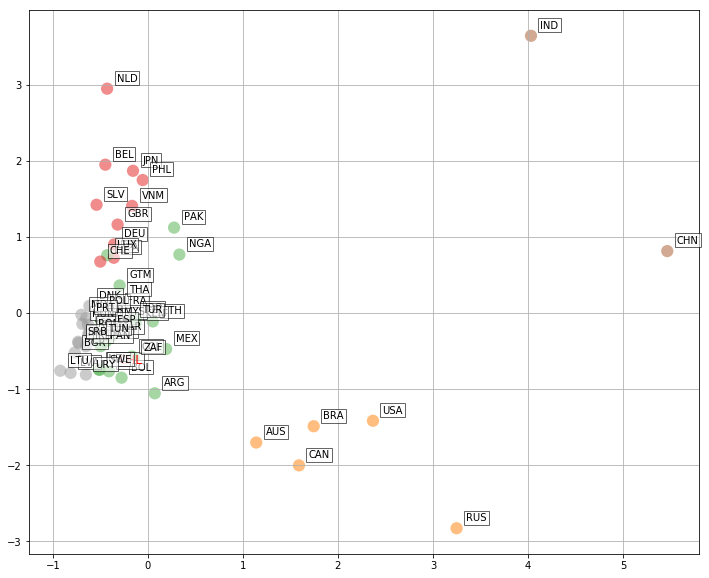

In [12]:
pca = PCA(n_components=2)
world_data_projected = pca.fit_transform(world_data_scaled)
print("Varianza explicada por los primeros componentes principales:")
print(pca.explained_variance_ratio_)
print("Suma acumulada de los primeros componentes principales: %f" % np.sum(pca.explained_variance_ratio_))
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(world_data_projected[:, 0], world_data_projected[:, 1], 
           c=pred_labels/clustering.n_clusters, linewidth=0, alpha=0.5, s=150, cmap='Set1')
for i in range(N):
    if world_labels_short[i] == "CHL":
        ax.annotate(world_labels_short[i], 
                    xy=(world_data_projected[i, 0]+0.1, world_data_projected[i, 1]+0.1), fontsize=12, color='r',
                   bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})
    else:
        ax.annotate(world_labels_short[i], 
                    xy=(world_data_projected[i, 0]+0.1, world_data_projected[i, 1]+0.1), fontsize=10,
                   bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})
plt.grid()

## B.6 SOM

- Para los criterios de agrupación (a), (b), (c) y (d) use los datos normalizados
- Para el criterio de agrupación (e) use los datos proyectados con PCA (90% varianza acumulada)

In [13]:
som_data = world_data_scaled # Datos normalizados
#som_data = world_data_projected # Componentes principales
som_size = [30, 25]
sm = MiniSom(som_size[0], som_size[1], som_data.shape[1], 
             sigma=np.amax(som_size)/4, sigma_final=np.amax(som_size)/16,
             learning_rate=0.5, learning_rate_final=0.05)
print("Error de cuantización (inicial): %f" %(sm.quantization_error(som_data)))
# Ajuste grueso
sm.train_batch(som_data, 1000)
print("Error de cuantización (ajuste grueso): %f" %(sm.quantization_error(som_data)))
# Ajuste fino
sm.sigma = np.amax(som_size)/16
sm.sigma_final = 1.0
sm.learning_rate = 0.05
sm.learning_rate_final = 0.005
sm.train_batch(som_data, 2000)
print("Error de cuantización (ajuste fino): %f" %(sm.quantization_error(som_data)))

Error de cuantización (inicial): 1.290909
Error de cuantización (ajuste grueso): 1.347083
Error de cuantización (ajuste fino): 1.234208


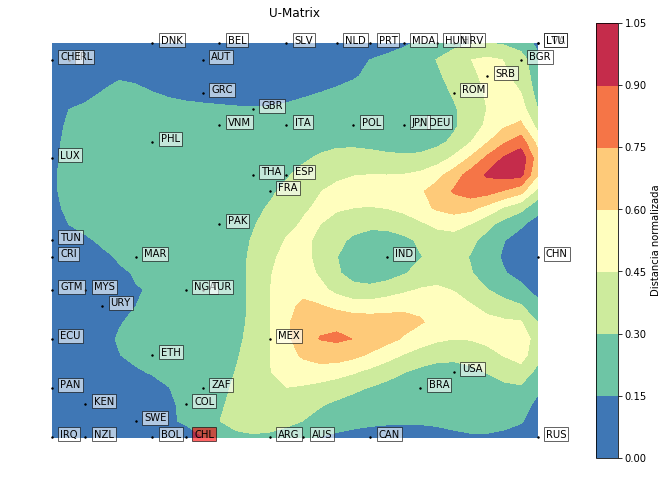

In [14]:
# U-Matrix
umat = sm.distance_map()
fig = plt.figure(figsize=(12, 8)) 
ax = fig.add_subplot(1, 1, 1)
cf = ax.contourf(umat.T, cmap=plt.cm.Spectral_r)
plt.colorbar(cf, label='Distancia normalizada')
plt.title('U-Matrix')
ax.axis('off')
for i in range(N):
    bmu = sm.winner(som_data[i, :])
    ax.scatter(bmu[0], bmu[1], s=2, c='k')
    if world_labels_short[i] == "CHL":
        ax.annotate(world_labels_short[i], xy=(bmu[0]+0.5, bmu[1]),
               bbox={'facecolor':'red', 'alpha':0.6, 'pad':2})
    else:
        ax.annotate(world_labels_short[i], xy=(bmu[0]+0.5, bmu[1]),
                   bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})

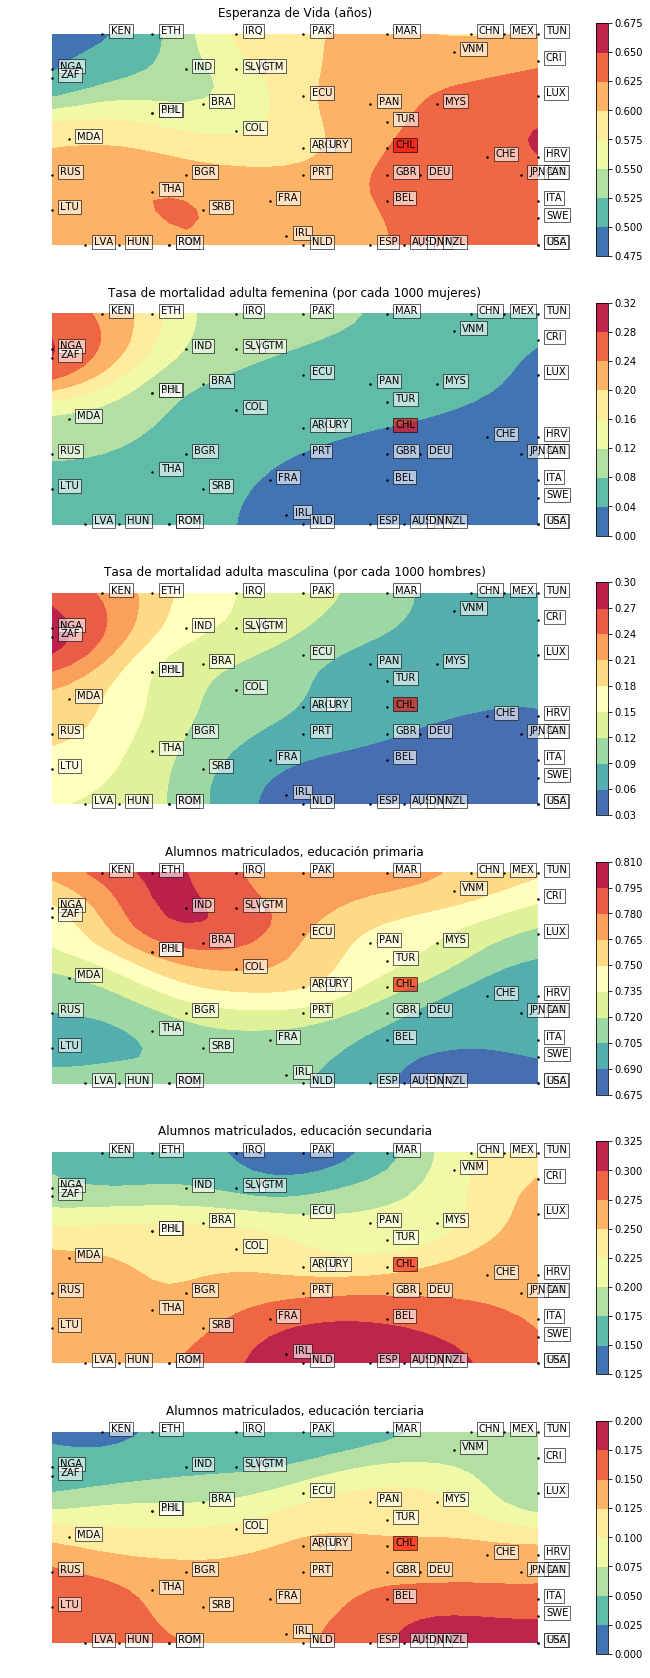

In [9]:
# Mapas de prototípos (uno por característica)
fig = plt.figure(figsize=(12, 5*som_data.shape[1]))
w = sm.weights
for i in range(w.shape[2]):
    ax = fig.add_subplot(w.shape[2], 1, i+1)
    cr = ax.contourf(w[:, :, i].T, cmap=plt.cm.Spectral_r)
    if som_data.shape[1] < 7:
        ax.set_title(feature_name[subset[i]])
    else:
        ax.set_title('PCA %d' %(i+1))
    plt.axis('off')
    plt.colorbar(cr)
    for j in range(N):
        bmu = sm.winner(som_data[j, :])
        ax.scatter(bmu[0], bmu[1], s=2, c='k')
        if world_labels_short[j] == "CHL":
            ax.annotate(world_labels_short[j], xy=(bmu[0]+0.5, bmu[1]),
                   bbox={'facecolor':'red', 'alpha':0.6, 'pad':2})
        else:
            ax.annotate(world_labels_short[j], xy=(bmu[0]+0.5, bmu[1]),
                       bbox={'facecolor':'white', 'alpha':0.6, 'pad':2})